## Surface Fluxes Taylor Series Expansion
This looks at the taylor series expansion of variables that contribute to each individual flux.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
import xarray as xr

from scipy.constants import Stefan_Boltzmann

from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots, colored_line
from isca_tools.utils.constants import R
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory
from isca_tools.thesis.surface_flux_taylor import get_latent_heat, get_sensitivity_lh, reconstruct_lh, name_nl, \
    name_square, reconstruct_sh, reconstruct_lw, get_sensible_heat, get_lwup_sfc_net, get_temp_rad, get_sensitivity_sh, \
    get_sensitivity_lw
import inspect
import copy
import jobs.thesis_season.thesis_figs.utils as utils
from isca_tools.utils.xarray import update_dim_slice

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [33]:
# Load actual data for check flux calculations match simulated and to do example decomposition
ds_base = utils.load_ds(depth=5, reduced_evap=True).isel(
    lat=-1).squeeze()  # only use one latitude, highest so the biggest seasonal cycle as a test
ds_test = ds_base.isel(lon=np.random.randint(0, ds_base.lon.size - 1), time=slice(0,
                                                                                  360))  # choose the first year at a single longitude (different each time) as sanity check formulae work
ds = utils.get_annual_zonal_mean(ds_base)  # smoothed average version

  0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
# Data for sanity check completely independent of ds
sigma_atm = 0.995
vals_ref = {'p_surf': 1000 * 100, 'evap_prefactor': 1, 'drag_coef': 0.0009, 'w_atm': 10, 'temp_diseqb': 5,
            'rh_atm': 0.7, 'temp_surf': 290,
            'temp_diseqb_r': 5, 'odp_surf': 6}
n_anom = 21
anom_max = {key: vals_ref[key] * 0.5 for key in vals_ref}
anom_max['temp_surf'] = 20
vals = {key: vals_ref[key] + np.linspace(-anom_max[key], anom_max[key], n_anom) for key in vals_ref}

vals_all = {f"{key}_ref": vals_ref[key] for key in vals_ref}  # include ref and arrays
for key in vals:
    vals_all[key] = vals[key]

## Latent Heat

Note that the `evap_prefactor`, `drag_coef` and `w_atm` plots all overlap because they have the same differential.

It works pretty well, giving confidence the equations are correct. For the mechanism combination on the right, I think the $T_s^2$ term is important, hence the deviation at extreme values.

In [35]:
vals_lh = {key2: vals_all[key2] for key2 in
           [key for key in vals_all if key in inspect.signature(reconstruct_lh).parameters]}
lh_ref, _, _, info_cont_lh = reconstruct_lh(**vals_lh, sigma_atm=sigma_atm, numerical=False)
info_cont_lh_num = reconstruct_lh(**vals_lh, sigma_atm=sigma_atm, numerical=True)[-1]

# For nonlinear contribution make temp_surf_anom always positive so combination of mechanisms goes from neg to pos
# I.e., anom_temp_surf * anom_var goes from negative to positive
vals_lh_nl = copy.deepcopy(vals_lh)
vals_lh_nl['temp_surf'] = vals_ref['temp_surf'] + np.abs(vals['temp_surf'] - vals_ref['temp_surf'])
var = reconstruct_lh(**vals_lh_nl, sigma_atm=sigma_atm, numerical=False)[-1]
var2 = reconstruct_lh(**vals_lh_nl, sigma_atm=sigma_atm, numerical=True)[-1]
for key in info_cont_lh:
    if ('nl' in key) and ('square' not in key):
        info_cont_lh[key] = var[key]
        info_cont_lh_num[key] = var2[key]

In [36]:
colors_use = {'p_surf': 'C5', 'evap_prefactor': 'C6', 'drag_coef': 'C4', 'w_atm': 'C3', 'temp_diseqb': 'C2',
              'rh_atm': 'C0', 'temp_surf': 'C1', 'temp_diseqb_r': 'C3', 'odp_surf': 'C0'}
symb_var = {'temp_surf': 'T_s', 'temp_diseqb': 'T_{dq}', 'temp_diseqb_r': 'T_{dq,r}', 'odp_surf': '\\tau_s'}

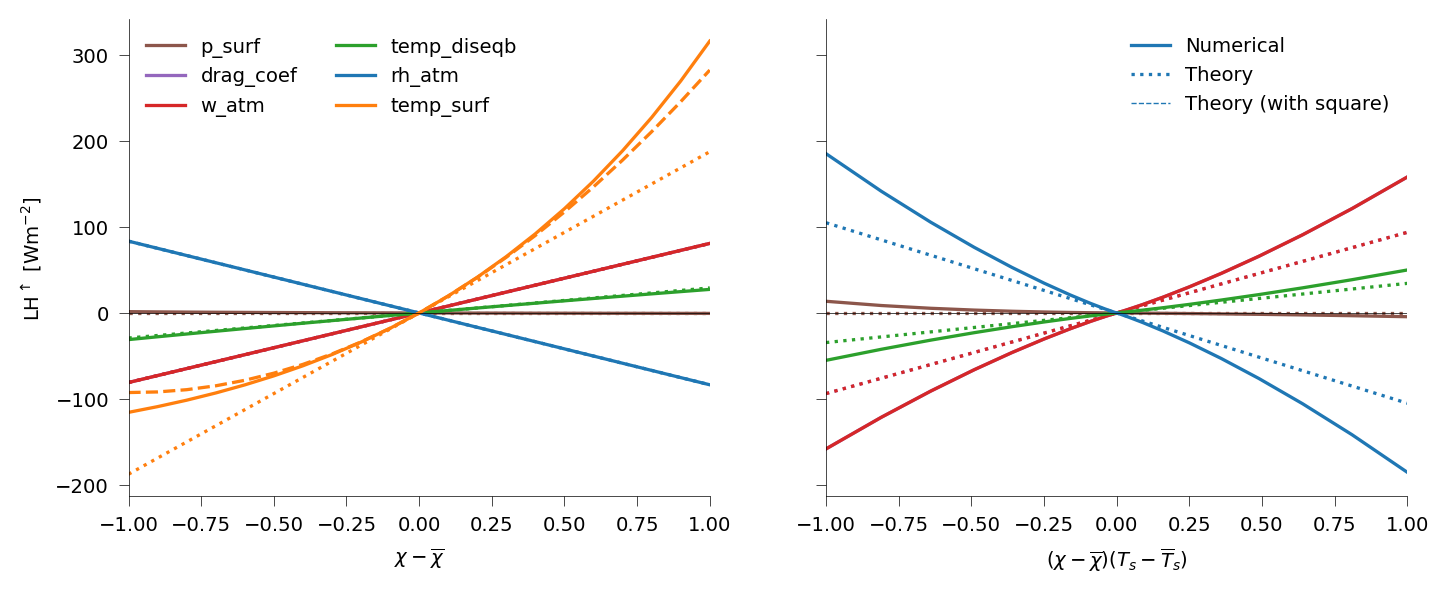

In [37]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'] * 1.5)
for i, key in enumerate(vals_lh):
    if 'ref' in key:
        continue
    ax[0].plot((vals[key] - vals_ref[key]) / anom_max[key], info_cont_lh_num[key], color=colors_use[key], label=key)
    ax[0].plot((vals[key] - vals_ref[key]) / anom_max[key], info_cont_lh[key], color=colors_use[key], linestyle=':')
    if name_square(key) in info_cont_lh:
        ax[0].plot((vals[key] - vals_ref[key]) / anom_max[key], info_cont_lh[key] + info_cont_lh[name_square(key)],
                   color=colors_use[key], linestyle='--')
    else:
        # NL combination with temp_surf
        var = (vals_lh_nl['temp_surf'] - vals_ref['temp_surf']) * (vals_lh_nl[key] - vals_ref[key])
        ax[1].plot(var / np.max(var), info_cont_lh_num[name_nl('temp_surf', key)], color=colors_use[key],
                   label='Numerical' if key == 'rh_atm' else None)
        ax[1].plot(var / np.max(var), info_cont_lh[name_nl('temp_surf', key)], color=colors_use[key],
                   linestyle=':', label='Theory' if key == 'rh_atm' else None)
ax[0].set_ylabel(f"{utils.style_map['lh'][2]} ""[Wm$^{-2}$]")
ax[0].set_xlabel('$\chi-\overline{\chi}$')
ax[1].set_xlabel('$(\chi-\overline{\chi})(T_s-\overline{T}_s)$')
update_linewidth(fig)
ax[0].legend(ncol=2)
ax[1].plot(-10, 0, color=colors_use['rh_atm'], linestyle='--', label='Theory (with square)')
ax[1].legend()
ax[0].set_xlim(-1, 1)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
update_fontsize(fig, 6)
plt.show()

#### Sanity Check
This sanity check just compares latent heat output from an actual dataset with that computed using `get_latent_heat` for a specific lon, lat, and year to check that the formula works.

In [38]:
# Sanity check that get_latent_heat matches model output
show_plot = False
flux_lhe_manual = get_latent_heat(ds_test.temp_surf, ds_test.temp_diseqb, ds_test.rh_atm,
                                  ds_test.w_atm, ds_test.drag_coef, ds_test.p_surf, ds_test.p_atm,
                                  ds_test.evap_prefactor)
if show_plot:
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    fig_resize(fig, width['two_col'] * 1.5)
    ds_test.flux_lhe.plot(ax=ax[0], color='k', label='Simulated')
    flux_lhe_manual.plot(ax=ax[0], color='k', linestyle=':', label='Manual')
    ((ds_test.flux_lhe - flux_lhe_manual)).plot(ax=ax[1], color='k')
    ax[0].legend()
    update_linewidth(fig)
    ax[0].axhline(0, color='k', lw=ax_linewidth)
    ax[1].axhline(0, color='k', lw=ax_linewidth)
    ax[0].set_ylabel(utils.style_map['lh'][2] + " [Wm-2]")
    ax[1].set_ylabel("Simulated - Manual [Wm-2]")
    plt.show()
flux_lhe_error = float(np.abs(flux_lhe_manual - ds_test.flux_lhe).quantile(0.9))
print(f"90th percentile Error: {flux_lhe_error:.1f} Wm-2")
if flux_lhe_error > 5:
    raise ValueError('High flux_t_error')

90th percentile Error: 0.1 Wm-2


## Sensible Heat

Note that the `p_surf`, `drag_coef` and `w_atm` plots all overlap because they have the same differential.

It works very well, giving confidence the equations are correct. It is clear that no squared terms are important here, and maybe only the nonlinear contribution between `w_atm` and `temp_diseqb`.

In [39]:
vals_sh = {key2: vals_all[key2] for key2 in
           [key for key in vals_all if key in inspect.signature(reconstruct_sh).parameters]}
sh_ref, _, _, info_cont_sh = reconstruct_sh(**vals_sh, sigma_atm=sigma_atm, numerical=False)
info_cont_sh_num = reconstruct_sh(**vals_sh, sigma_atm=sigma_atm, numerical=True)[-1]

# For nonlinear contribution make temp_surf_anom always positive so combination of mechanisms goes from neg to pos
# I.e., anom_temp_surf * anom_var goes from negative to positive
vals_sh_nl = copy.deepcopy(vals_sh)
vals_sh_nl['temp_diseqb'] = vals_ref['temp_diseqb'] + np.abs(vals['temp_diseqb'] - vals_ref['temp_diseqb'])
var = reconstruct_sh(**vals_sh_nl, sigma_atm=sigma_atm, numerical=False)[-1]
var2 = reconstruct_sh(**vals_sh_nl, sigma_atm=sigma_atm, numerical=True)[-1]
for key in info_cont_sh:
    if ('nl' in key) and ('square' not in key):
        info_cont_sh[key] = var[key]
        info_cont_sh_num[key] = var2[key]

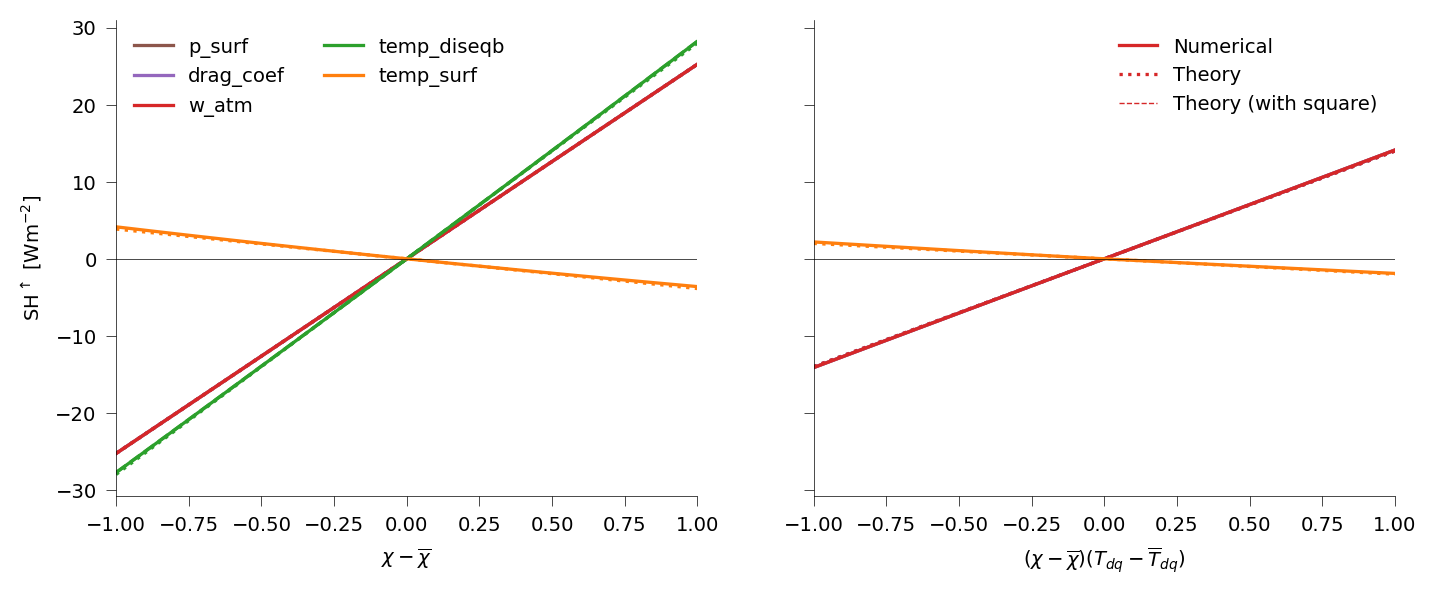

In [40]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'] * 1.5)
for i, key in enumerate(vals_sh):
    if 'ref' in key:
        continue
    ax[0].plot((vals[key] - vals_ref[key]) / anom_max[key], info_cont_sh_num[key], color=colors_use[key], label=key)
    ax[0].plot((vals[key] - vals_ref[key]) / anom_max[key], info_cont_sh[key], color=colors_use[key], linestyle=':')
    if name_square(key) in info_cont_sh:
        ax[0].plot((vals[key] - vals_ref[key]) / anom_max[key], info_cont_sh[key] + info_cont_sh[name_square(key)],
                   color=colors_use[key], linestyle='--')
    else:
        # NL combination with temp_surf
        var = (vals_sh_nl['temp_diseqb'] - vals_ref['temp_diseqb']) * (vals_sh_nl[key] - vals_ref[key])
        if name_nl('temp_diseqb', key) in info_cont_sh:
            key2 = name_nl('temp_diseqb', key)
        else:
            key2 = name_nl(key, 'temp_diseqb')
        ax[1].plot(var / np.max(var), info_cont_sh_num[key2], color=colors_use[key],
                   label='Numerical' if key == 'w_atm' else None)
        ax[1].plot(var / np.max(var), info_cont_sh[key2], color=colors_use[key],
                   linestyle=':', label='Theory' if key == 'w_atm' else None)
ax[0].set_ylabel(f"{utils.style_map['sh'][2]} ""[Wm$^{-2}$]")
ax[0].set_xlabel('$\chi-\overline{\chi}$')
ax[1].set_xlabel('$(\chi-\overline{\chi})(T_{dq}-\overline{T}_{dq})$')
update_linewidth(fig)
ax[0].legend(ncol=2)
ax[1].plot(-10, 0, color=colors_use['w_atm'], linestyle='--', label='Theory (with square)')
ax[1].legend()
ax[0].set_xlim(-1, 1)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
update_fontsize(fig, 6)
plt.show()

#### Sanity Check

In [41]:
# Sanity check that get_sensible_heat matches model output
show_plot = False
flux_t_manual = get_sensible_heat(ds_test.temp_surf, ds_test.temp_diseqb,
                                  ds_test.w_atm, ds_test.drag_coef, ds_test.p_surf, ds_test.p_atm)
if show_plot:
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    fig_resize(fig, width['two_col'] * 1.5)
    ds_test.flux_t.plot(ax=ax[0], color='k', label='Simulated')
    flux_t_manual.plot(ax=ax[0], color='k', linestyle=':', label='Manual')
    ((ds_test.flux_t - flux_t_manual)).plot(ax=ax[1], color='k')
    ax[0].legend()
    update_linewidth(fig)
    ax[0].axhline(0, color='k', lw=ax_linewidth)
    ax[1].axhline(0, color='k', lw=ax_linewidth)
    ax[0].set_ylabel(utils.style_map['sh'][2] + " [Wm-2]")
    ax[1].set_ylabel("Simulated - Manual [Wm-2]")
    plt.show()
flux_t_error = float(np.abs(flux_t_manual - ds_test.flux_t).quantile(0.9))
print(f"90th Percentile Error: {flux_t_error:.1f} Wm-2")
if flux_t_error > 5:
    raise ValueError('High flux_t_error')

90th Percentile Error: 0.5 Wm-2


## Longwave
Note that the `temp_diseqb` and `temp_diseqb_r` plots all overlap because they have the same differential.

It works very well, giving confidence the equations are correct. Only important square terms ar those involving optical depth, which is constant for us.
The nonlinear combination of `temp_diseqb` and `t_surf` could be significant.

In [42]:
vals_lw = {key2: vals_all[key2] for key2 in
           [key for key in vals_all if key in inspect.signature(reconstruct_lw).parameters]}
lw_ref, _, _, info_cont_lw = reconstruct_lw(**vals_lw, numerical=False)
info_cont_lw_num = reconstruct_lw(**vals_lw, numerical=True)[-1]

# For nonlinear contribution make temp_surf_anom always positive so combination of mechanisms goes from neg to pos
# I.e., anom_temp_surf * anom_var goes from negative to positive

vals_lw_nl = copy.deepcopy(vals_lw)
key_nl_mech_use = 'temp_surf'  # have option for all mechanisms in lw
vals_lw_nl[key_nl_mech_use] = vals_ref[key_nl_mech_use] + np.abs(vals[key_nl_mech_use] - vals_ref[key_nl_mech_use])
var = reconstruct_lw(**vals_lw_nl, numerical=False)[-1]
var2 = reconstruct_lw(**vals_lw_nl, numerical=True)[-1]
for key in info_cont_lw:
    if ('nl' in key) and ('square' not in key):
        info_cont_lw[key] = var[key]
        info_cont_lw_num[key] = var2[key]

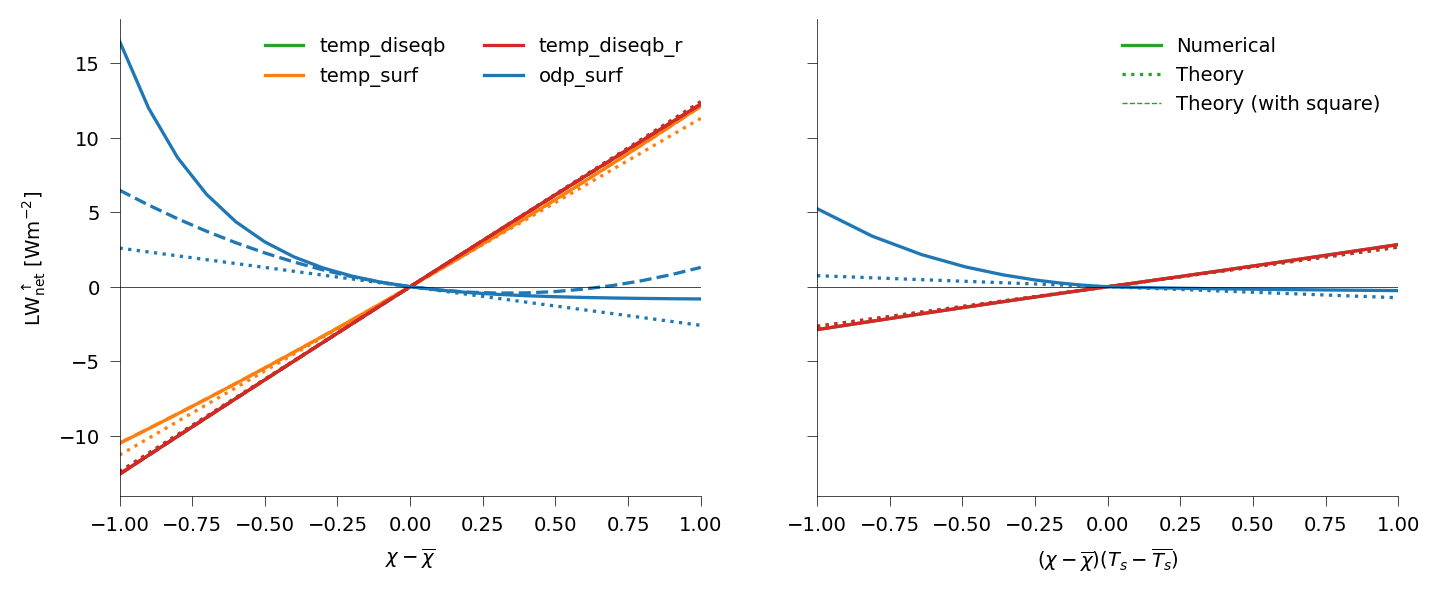

In [43]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'] * 1.5)
j = 0
for i, key in enumerate(vals_lw):
    if 'ref' in key:
        continue
    ax[0].plot((vals[key] - vals_ref[key]) / anom_max[key], info_cont_lw_num[key], color=colors_use[key], label=key)
    ax[0].plot((vals[key] - vals_ref[key]) / anom_max[key], info_cont_lw[key], color=colors_use[key], linestyle=':')
    if name_square(key) in info_cont_lw:
        ax[0].plot((vals[key] - vals_ref[key]) / anom_max[key], info_cont_lw[key] + info_cont_lw[name_square(key)],
                   color=colors_use[key], linestyle='--')
    if key != key_nl_mech_use:
        # NL combination with temp_surf
        var = (vals_lw_nl[key_nl_mech_use] - vals_ref[key_nl_mech_use]) * (vals_lw_nl[key] - vals_ref[key])
        if name_nl(key_nl_mech_use, key) in info_cont_lw:
            key2 = name_nl(key_nl_mech_use, key)
        else:
            key2 = name_nl(key, key_nl_mech_use)
        ax[1].plot(var / np.max(var), info_cont_lw_num[key2], color=colors_use[key],
                   label='Numerical' if j == 0 else None)
        ax[1].plot(var / np.max(var), info_cont_lw[key2], color=colors_use[key],
                   linestyle=':', label='Theory' if j == 0 else None)
        j += 1
ax[0].set_ylabel(f"{utils.style_map['lw'][2]} ""[Wm$^{-2}$]")
ax[0].set_xlabel('$\chi-\overline{\chi}$')
ax[1].set_xlabel('$(\chi-\overline{\chi})'
                 f'({symb_var[key_nl_mech_use]}-\overline{"{" + symb_var[key_nl_mech_use] + "}"})$')
update_linewidth(fig)
ax[0].legend(ncol=2)
ax[1].plot(-10, 0, color=colors_use['temp_diseqb'], linestyle='--', label='Theory (with square)')
ax[1].legend()
ax[0].set_xlim(-1, 1)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
update_fontsize(fig, 6)
plt.show()

#### Sanity Check

In [44]:
# Sanity check that get_lwup_sfc_net matches model output
# By definition of temp_rad, lwdn_sfc is exact
# Difference is due to lwup, probably due to taking average over daily cycle
show_plot = False
lwup_sfc_manual = Stefan_Boltzmann * ds_test.temp_surf ** 4
lwdn_sfc_manual = lwup_sfc_manual - get_lwup_sfc_net(ds_test.temp_surf, ds_test.temp_diseqb,
                                                     ds_test.temp_diseqb_r, ds_test.odp_surf)
if show_plot:
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    fig_resize(fig, width['two_col'] * 1.5)
    ds_test.lwup_sfc.plot(ax=ax[0], color='C0', label='Simulated')
    lwup_sfc_manual.plot(ax=ax[0], color='C0', linestyle=':', label='Manual')
    ((ds_test.lwup_sfc - lwup_sfc_manual)).plot(ax=ax[1], color='C0', label='$LW^{\\uparrow}$')
    ds_test.lwdn_sfc.plot(ax=ax[0], color='C1')
    lwdn_sfc_manual.plot(ax=ax[0], color='C1', linestyle=':')
    ((ds_test.lwdn_sfc - lwdn_sfc_manual)).plot(ax=ax[1], color='C1', label='$LW^{\downarrow}$')
    ax[0].legend()
    ax[1].legend()
    update_linewidth(fig)
    ax[0].axhline(0, color='k', lw=ax_linewidth)
    ax[1].axhline(0, color='k', lw=ax_linewidth)
    ax[0].set_ylabel(utils.style_map['lw'][2] + " [Wm-2]")
    ax[1].set_ylabel("Simulated - Manual [Wm-2]")
    plt.show()
lwup_sfc_error = float(np.abs(lwup_sfc_manual - ds_test.lwup_sfc).max())
lwdn_sfc_error = float(np.abs(lwdn_sfc_manual - ds_test.lwdn_sfc).max())
print(f"LW Up Max Error: {lwup_sfc_error:.1f} Wm-2")
print(f"LW Down Max Error: {lwdn_sfc_error:.1f} Wm-2")
if lwup_sfc_error > 1:
    raise ValueError('High lwup_sfc_error')
if lwdn_sfc_error > 0.01:
    raise ValueError('High lwdn_sfc_error')

LW Up Max Error: 0.2 Wm-2
LW Down Max Error: 0.0 Wm-2


## Example Decomposition
Below I look at a smoothed dataset for a given latitude averaged over all longitudes and years. I plot the contribution from each variable to the variation of the flux with time over the year using the taylor series decomposition.

In [45]:
flux_ref = {}
flux_approx = {'lh': {'simulated': ds.flux_lhe,
                      'post_av': get_latent_heat(ds.temp_surf, ds.temp_diseqb, ds.rh_atm,
                                                 ds.w_atm, ds.drag_coef, ds.p_surf, ds.p_atm, ds.evap_prefactor)},
               'sh': {'simulated': ds.flux_t,
                      'post_av': get_sensible_heat(ds.temp_surf, ds.temp_diseqb, ds.w_atm, ds.drag_coef, ds.p_surf,
                                                   ds.p_atm)},
               'lw': {'simulated': ds.lw_sfc,
                      'post_av': get_lwup_sfc_net(ds.temp_surf, ds.temp_diseqb, ds.temp_diseqb_r, ds.odp_surf)}}

ds_av = ds.mean(dim='time', keep_attrs=True)
flux_cont = {'lh': {}, 'sh': {}, 'lw': {}}
for key in flux_cont:
    for key2 in ['theory', 'numerical']:
        flux_ref[key], flux_approx[key][key2], flux_approx[key][f"{key2}_nl"], flux_cont[key][key2] = \
            utils.reconstruct_flux_xr(ds, ds_av, flux_name=key, numerical=key2 == "numerical")
    for key2 in list(flux_approx[key].keys())[2:]:
        flux_approx[key][key2] += flux_ref[key]  # for all but simulated and post_av, need to add ref
    if key in ['lh', 'lw']:
        flux_cont[key]["theory"]["temp_surf"] += flux_cont[key]["theory"][
            name_square('temp_surf')]  # combine linear and square temp_surf cont

In [46]:
style_map = {'simulated': ('k', '-', 'Simulated'), 'post_av': ('k', ':', 'Manual'), 'theory': ('C0', '-', 'Theory'),
             'theory_nl': ('C0', '--', 'Theory - nl'), 'numerical': ('C1', '-', 'Numerical'),
             'numerical_nl': ('C1', '--', 'Numerical - nl')}

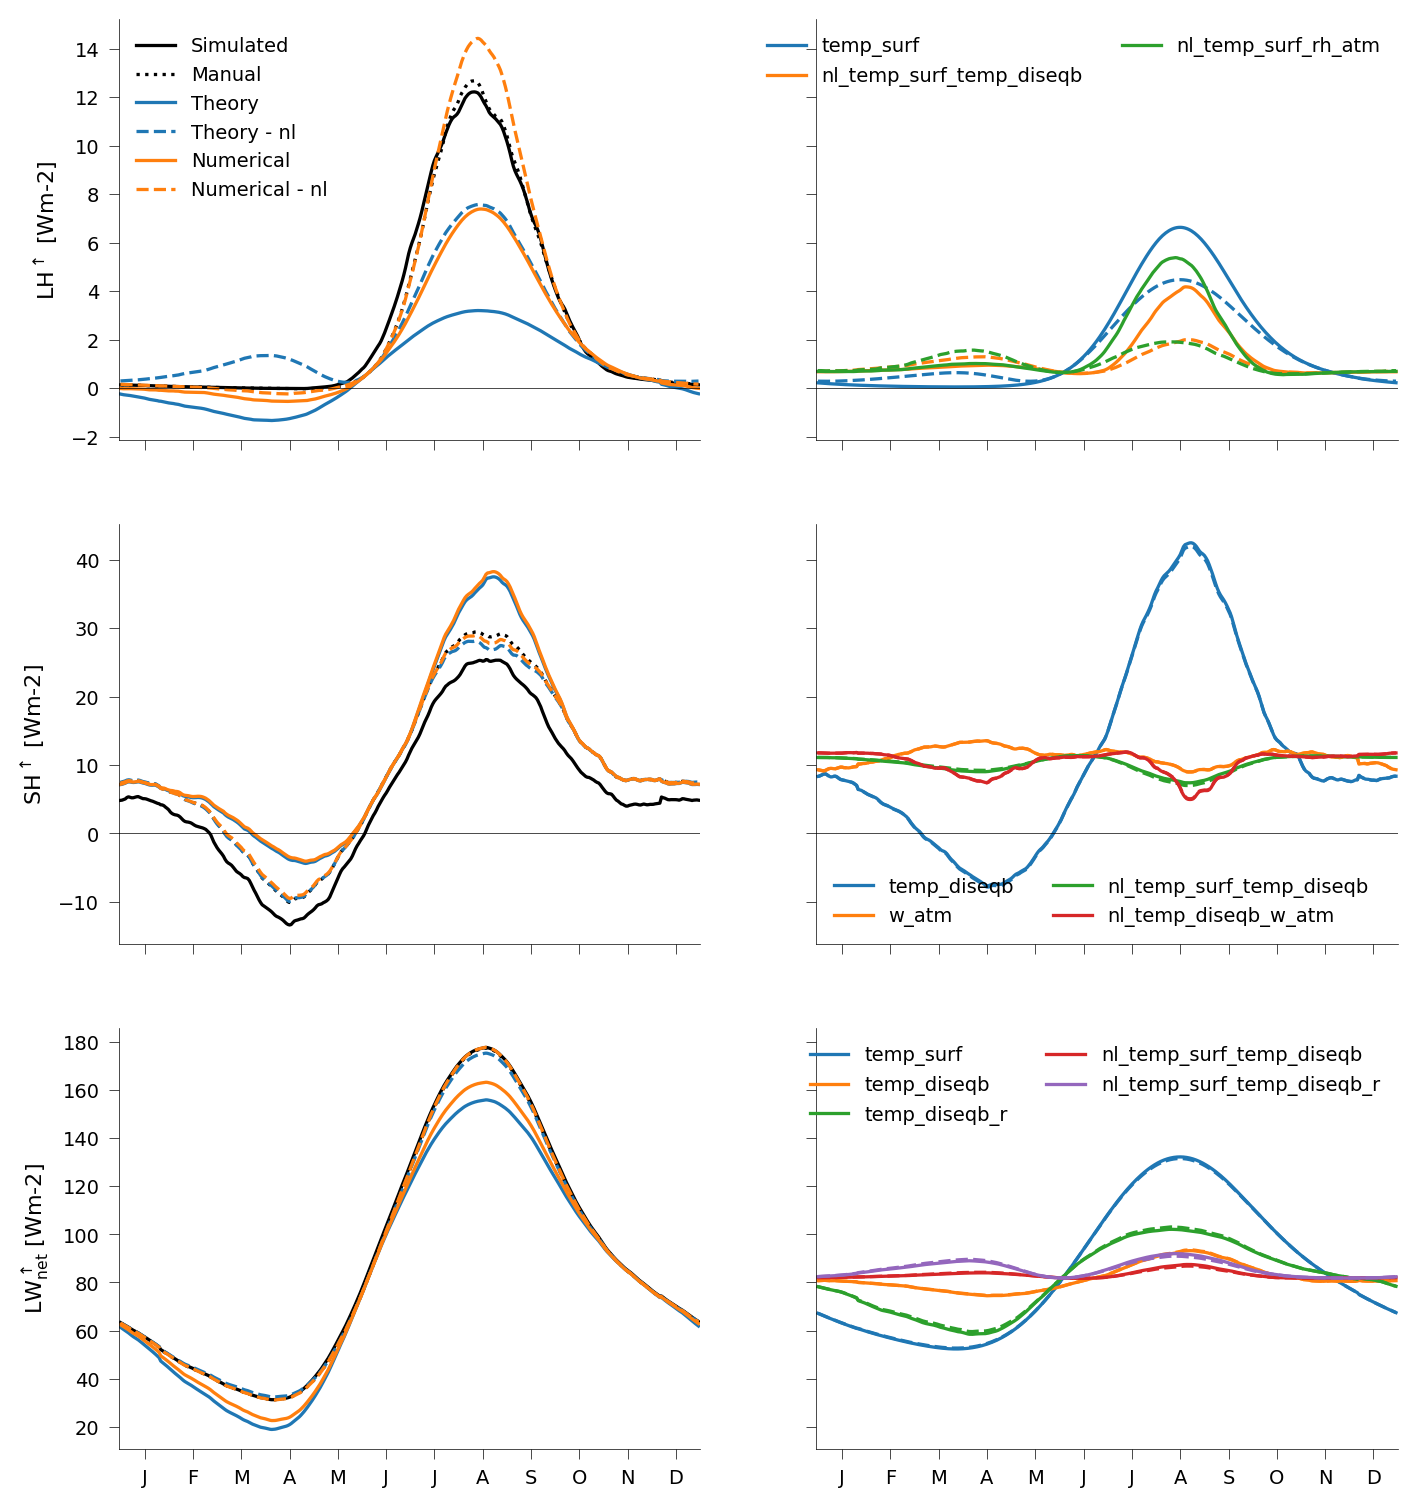

In [47]:
mech_thresh = 2  # Only mechanisms with Wm-2 greater than this are shown
fig, ax = plt.subplots(3, 2, sharex=True, sharey='row')
fig_resize(fig, width['two_col'] * 1.5)
for i, key in enumerate(flux_approx.keys()):
    ax[i, 0].set_ylabel(utils.style_map[key][2] + " [Wm-2]")
    for key2 in flux_approx[key]:
        ax[i, 0].plot(ds.time, flux_approx[key][key2], color=style_map[key2][0], linestyle=style_map[key2][1],
                      label=style_map[key2][2])
    j = 0
    for key2 in flux_cont[key]["numerical"]:
        if key2 == 'residual':
            continue
        if np.abs(flux_cont[key]["numerical"][key2]).max() > mech_thresh:
            ax[i, 1].plot(ds.time, flux_ref[key] + flux_cont[key]["numerical"][key2], label=key2, color=f"C{j}")
            if key2 in flux_cont[key]["theory"]:
                ax[i, 1].plot(ds.time, flux_ref[key] + flux_cont[key]["theory"][key2], color=f"C{j}", linestyle='--')
            j += 1
update_linewidth(fig)
ax[0, 0].legend()
ax[0, 0].set_xlim(-1, 360)
for i, ax_use in enumerate(ax.flatten()):
    if i % 2:
        ax_use.legend(ncol=2)
    if ax_use.get_ylim()[0] < 0:
        ax_use.axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].set_xticks(*utils.month_ticks)
plt.show()

## Link to empirical fitting
Now that we see that the Taylor series approximation is decent, we would like to relate it to our empirical fitting.

We do this by fitting the same empirical fitting to each of the variables above (for non linear and square terms, we fit a separate fitting, don't compute from the individual fitting variables). Then we multiply these empirical variables with the taylor series coefficients to obtain the approximate contribution from each variable.

### Variable empirical fitting
First we do the empirical fitting for each of the variables, square terms, and non linear combinations separately.

In [19]:
ds_empirical_ref, var_params, ds_empirical, var_fit_error = utils.get_empirical_var_fit(ds[utils.style_map_var.keys()], error_norm_dim=None)
ds_empirical_ref.attrs = ds_av.attrs
for key in ['sigma_atm', 'odp_surf', 'evap_prefactor']:
    ds_empirical_ref[key] = ds_av[key]

### Error in variable fitting
Below I plot the error in the fitting of each variable for the chosen latitude.

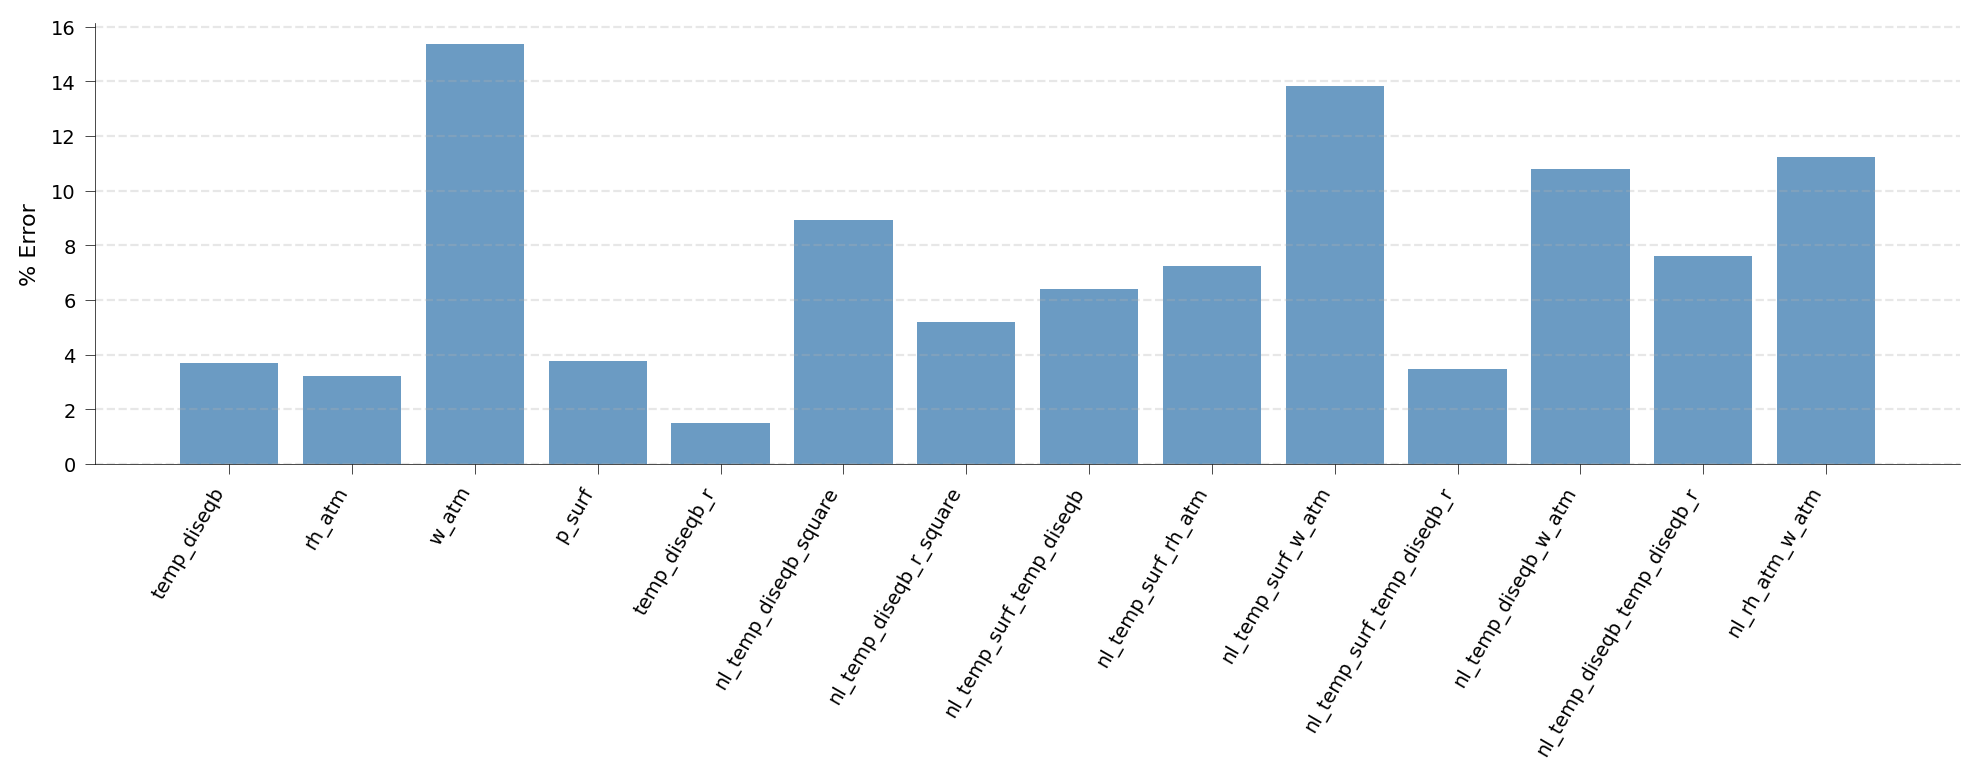

In [20]:
def plot_scalar_ds_bar(ds, var_ignore=None, ax=None, *, rotation=60):
    """Plot a single bar chart of scalar Dataset values (key -> value).

    Designed for the case in your screenshot where each `ds.data_vars[name]` is
    0D (a single number). Variables in `var_ignore` are skipped.

    Args:
        ds: xarray.Dataset. Expected to contain (mostly) 0D data variables.
        var_ignore: List of variable names to exclude.
        ax: Optional matplotlib Axes to draw on. If None, a new figure/axes is created.
        rotation: Rotation angle for x tick labels (degrees).

    Returns:
        fig: matplotlib Figure.
        ax: matplotlib Axes.
    """
    if var_ignore is None:
        var_ignore = []

    keys = [k for k in ds.data_vars.keys() if k not in set(var_ignore)]
    if len(keys) == 0:
        raise ValueError("No variables left to plot after applying var_ignore.")

    # Extract scalar values (works for 0D arrays; also handles size==1 arrays).
    vals = []
    kept_keys = []
    for k in keys:
        da = ds[k]
        if da.size != 1:
            # If you truly only want scalars, skip non-scalars explicitly.
            continue
        kept_keys.append(k)
        vals.append(float(da.values.reshape(-1)[0]))

    if len(kept_keys) == 0:
        raise ValueError("No scalar (size==1) variables found to plot.")

    x = np.arange(len(kept_keys))

    if ax is None:
        fig, ax = plt.subplots(figsize=(max(10, 0.35 * len(kept_keys)), 4))
    else:
        fig = ax.figure

    ax.bar(x, vals, color="steelblue", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(kept_keys, rotation=rotation, ha="right")
    ax.set_ylabel("Value")
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    fig.tight_layout()

    return fig, ax

var_ignore = [key for key in var_fit_error if "_p_surf" in key]  # or whatever you want to omit
var_ignore += [name_square('rh_atm'), name_square('w_atm')]     # never see these terms
for key in var_fit_error:
    if "nl" in key and "temp_diseqb_r" in key and (("w_atm" in key) or ("rh_atm" in key)):
        # These never come up
        var_ignore.append(key)
fig, ax = plot_scalar_ds_bar(var_fit_error, var_ignore=var_ignore)
ax.set_ylabel('% Error')
plt.show()


In [21]:
def get_var_sim(key):
    # Function to get simulated value of the variable indicated by key
    if 'square' in key:
        key2 = key.replace('nl_', '').replace('_square', '')
        var = (ds[key2] - ds_empirical_ref[key2]) ** 2
    elif 'nl' in key:
        var = None
        for var1, var2 in itertools.combinations(["temp_surf", "temp_diseqb", "rh_atm", "w_atm", "p_surf", "temp_diseqb_r"], 2):
            if key == name_nl(var1, var2):
                var = (ds[var1] - ds_empirical_ref[var1]) * (ds[var2] - ds_empirical_ref[var2])
                break
        if var is None:
            raise ValueError(f'No found {key}')
    else:
        var = ds[key]
    return var

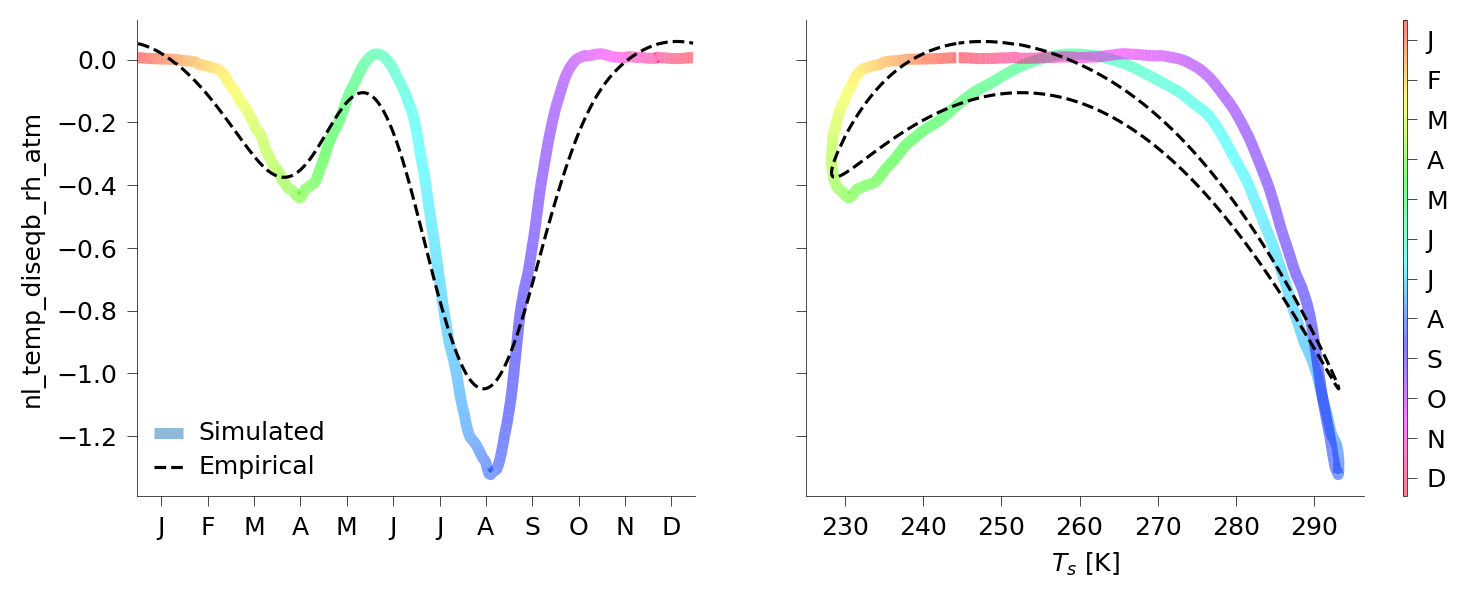

Fitting Error: 8.1%


In [31]:
key = 'nl_temp_diseqb_rh_atm'
var = get_var_sim(key)
fig, ax = plt.subplots(1, 2, sharex=False, sharey=True)
fig_resize(fig, width['two_col'] * 1.5)
for i in range(len(ax)):
    im = colored_line(ds.time if i == 0 else ds.temp_surf, var, c=ds.time,
                      ax=ax[i], cmap='hsv', label='Simulated', lw=4, alpha=0.5)
ax[0].plot(ds.time, ds_empirical[key], color='k', linestyle='--', label='Empirical')
ax[1].plot(ds.temp_surf, ds_empirical[key], color='k', linestyle='--', label='Empirical')
cbar = fig.colorbar(im, ax=ax.ravel().tolist() if len(ax) > 1 else ax[0], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*utils.month_ticks)
update_linewidth(fig)
ax[0].legend(handlelength=utils.leg_handlelength)
try:
    ax[0].set_ylabel(f"{utils.style_map_var[key][2]} [{utils.style_map_var[key][3]}]")
except KeyError:
    ax[0].set_ylabel(key)
ax[1].set_xlabel(f"{utils.style_map_var['temp_surf'][2]} [{utils.style_map_var['temp_surf'][3]}]")
ax[0].set_xticks(*utils.month_ticks)
ax[0].set_xlim(utils.ax_lims_time)
update_fontsize(fig)
plt.show()
print(f"Fitting Error: {var_fit_error[key]:.1f}%")

### Obtaining Flux Estimates
With these empirical variables, we multiply them by the relevant taylor series coefficient and sum them up. This is given by the blue dashed line below, which is a good match to the blue line using the actual variables.

To link it to the empirical fitting, we compute the overall empirical fitting parameters by summing up the individual contributions from each variable. Using these summed empirical fitting parameters, we do the empirical fitting. This is shown by the dashed orange line below, and compared to the vanilla empirical fitting in solid orange.

It is clear that the dashed orange line is a compromise between the taylor series and direct empirical fitting.

**Important point** is that sensitivity factors not calculated with mean value of each variable, but the empirical value of the variable with mean surface temperature, and all empirical constants set to 0 i.e. the deg=0 coefficient from the `polyfit` fitting. This is so as to match the form of the flux equation expected both from the taylor series and empirical fitting.

In [24]:
# Get sensitivity parameters i.e. taylor series coefficients for each variable and non linear term
# In taylor series expansion, expand about temp_surf_mean and all empirical fitting params set to zero
# This differs from the average of the variable if deg=2
# Important as affects the values used in gamma
ds_ref = ds_empirical_ref.copy(deep=True)
# ds_ref = ds_av.copy(deep=True)
flux_gamma = {key: utils.get_flux_sensitivity(ds_ref, key) for key in flux_cont}

In [25]:
# Get empirical param breakdown from contribution of each variable
flux_empirical_params = {}
for key2 in flux_cont:
    var_keep = [var for var in var_params if var in flux_gamma[key2]]
    flux_empirical_params[key2] = var_params[var_keep].copy(deep=True)
    for key in flux_gamma[key2]:
        if ('drag_coef' in key) or ('odp_surf' in key) or ('evap_prefactor' in key):
            # These variables constant in this case
            continue
        elif key in var_params:
            # Linear contribution from variable is just the lambda, lambda_cos, lambda_sin multiplied by the taylor coef
            flux_empirical_params[key2][key] *= flux_gamma[key2][key]
        elif key == 'temp_surf':
            flux_empirical_params[key2][key] = flux_empirical_params[key2]['temp_diseqb'] * 0  # initialize
            # Set temp surf values to exactly the taylor coefs
            flux_empirical_params[key2] = update_dim_slice(flux_empirical_params[key2], "deg", "1",
                                                           flux_gamma[key2][key], key)
            if name_square(key) in flux_gamma[key2]:
                flux_empirical_params[key2] = update_dim_slice(flux_empirical_params[key2], "deg", "2",
                                                               flux_gamma[key2][name_square(key)], key)
    flux_empirical_params[key2]['sum'] = flux_empirical_params[key2].to_array().sum("variable")
    for key in flux_empirical_params[key2]:
        # Make explicit that we did not compute the 0th harmonic coef here
        flux_empirical_params[key2] = update_dim_slice(flux_empirical_params[key2], 'deg', '0', 0, key)

In [26]:
# Actual fitting best possible to the post averaged variable computation of fluxes
for key2 in flux_empirical_params:
    flux_empirical_params[key2]['actual'] = utils.polyfit_phase_xr(ds.temp_surf - ds_av.temp_surf,
                                                                   flux_approx[key2]['post_av'], deg=2,
                                                                   include_phase=True, include_fourier=True)

In [27]:
# Get new estimates of fluxes
ds_empirical['temp_surf'] = ds.temp_surf
for key in flux_cont:
    # Use empirical fit to each variable, reconstruct using taylor series coefs
    # var is the reference value of the flux in the taylor series expansion calculated from ds_ref
    # Differs from ref calc from ds_av - important
    var, _, flux_approx[key]["taylor_empirical_vars"] = \
        utils.reconstruct_flux_xr(ds_empirical, ds_ref, flux_name=key, numerical=False)[:3]
    flux_approx[key]["taylor_empirical_vars"] += var  # for all but simulated and post_av, need to add ref
    # Using empirical fitting regardless of taylor coefs, find fit
    flux_approx[key]["empirical"] = utils.polyval_phase_xr(flux_empirical_params[key]['actual'], ds.temp_surf - ds_av.temp_surf)
    # Using empirical fitting where params are sum of params fit to individual variables multiplied by taylor series coefs
    flux_approx[key]["empirical_from_taylor_params"] = utils.polyval_phase_xr(flux_empirical_params[key]['sum'], ds.temp_surf - ds_av.temp_surf) + var

In [28]:
style_map_approx = {'post_av': ('k', '-', 'Simulated'), 'theory_nl': ('C0', '-', 'Taylor'),
                    'taylor_empirical_vars': ('C0', '--', 'Taylor (fit vars)'),
                    'empirical': ('C1', '-', 'Empirical'),
                    'empirical_from_taylor_params': ('C1', '--', 'Empirical (fit vars)')}

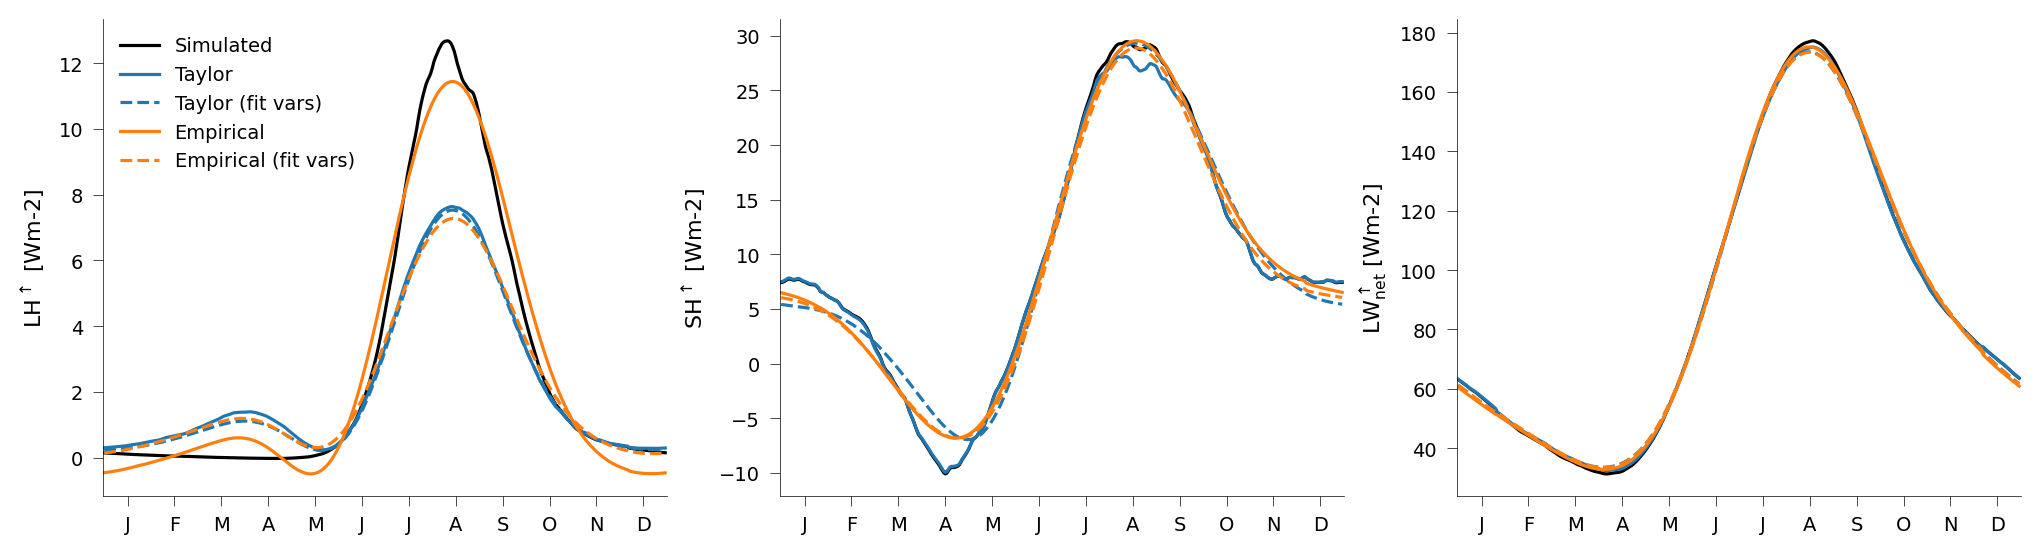

In [29]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=False)
fig_resize(fig, width['two_col']/2*3 * 1.5)

for i, key in enumerate(flux_approx.keys()):
    ax[i].set_ylabel(utils.style_map[key][2] + " [Wm-2]")
    for key2 in style_map_approx:
        ax[i].plot(ds.time, flux_approx[key][key2], color=style_map_approx[key2][0], linestyle=style_map_approx[key2][1],
                      label=style_map_approx[key2][2])
ax[0].set_xticks(*utils.month_ticks)
ax[0].set_xlim(utils.ax_lims_time)
update_linewidth(fig)
ax[0].legend()
plt.show()